# B value vs Nea. ancestry using f4 ratios

In [1]:
suppressPackageStartupMessages({

library(tidyverse)

source("../R/utils.R")
source("../x/admixr.R")
source("../R/assign_bvals.R")

})

Warning message:
“package ‘GenomicRanges’ was built under R version 3.3.3”Warning message:
“package ‘S4Vectors’ was built under R version 3.3.3”Warning message:
“package ‘IRanges’ was built under R version 3.3.3”Warning message:
“package ‘XVector’ was built under R version 3.3.3”

In [2]:
suppressMessages({

fix_name <- function(str) {
    str_replace_all(str, "-|\\.", "_") %>%
        str_replace_all("^S_|_[1-9]+", "")
}

# load the sample information
sgdp <- load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
    filter(! Region %in% c("Africa", "Oceania")) %>%
    select(-Country, pop=Region) %>%
    mutate(age=0, name=fix_name(name)) %>%
    group_by(name, age, pop) %>%
    summarise(Latitude=mean(Latitude), Longitude=mean(Longitude)) %>%
    ungroup
emhs <- read_delim("../clean_data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(pop="EMH", Latitude=NA, Longitude=NA) %>%
    filter(name != "Oase1")
samples <- bind_rows(emhs, sgdp)

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all/"

EIGENSTRAT_PREFIX <- paste0(EIGENSTRAT_DIR, "UPA_merged")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged.transitions.snp")

ADMIXTOOLS_PATH <- ""

In [4]:
dir.create("../admixtools")
setwd("../admixtools")

Warning message in dir.create("../admixtools"):
“'../admixtools' already exists”

## Load admixture array sites and the big Yoruba et al sites

In [5]:
f4_sites <- read_snp("../raw_data/eigenstrat_all/UPA_all.snp") %>%
    filter(chrom %in% 1:22) %>%
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE, keep.extra.columns=TRUE) %>% 
    assign_bvals(bval_path="../raw_data/bkgd/", chain_path="../raw_data/hg18ToHg19.over.chain") %>%
    as.data.frame %>%
    select(id, chrom=seqnames, pos, alt, ref, bval) %>%
    mutate(bin=cut(bval, seq(0, 1000, 100)))

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


In [6]:
nrow(f4_sites)

[1] 1946525

In [7]:
aa_sites <- read_tsv("../clean_data/ice_age.tsv") %>% 
    mutate(chrom=paste0("chr", chrom), start=pos - 1, end=pos) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE, keep.extra.columns=TRUE) %>% 
    assign_bvals(bval_path="../raw_data/bkgd/", chain_path="../raw_data/hg18ToHg19.over.chain") %>%
    as.data.frame %>%
    select(-seqnames, -pos, -start, -end, -ref, -alt, -width, -strand) %>%
    mutate(bin=cut(bval, seq(0, 1000, 100)))

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.


In [8]:
nrow(aa_sites)

[1] 945124

In [9]:
bval_files <- list.files("../raw_data/bkgd/", full.names = TRUE, ".*.bkgd")
bval_df_list <- lapply(bval_files, function(filename) {
    read.table(filename, col.names = c("bval", "length")) %>% 
        mutate(chr = str_replace(basename(filename), ".bkgd", 
            ""), end = cumsum(length), start = c(1, (end + 
            1)[-n()])) %>% select(chr, start, end, bval)
})
bval_regions_hg18 <- bind_rows(bval_df_list)

In [10]:
bvals <- bind_rows(
    data.frame(bval=f4_sites$bval, sites="big Yoruba + human origins"),
    data.frame(bval=aa_sites$bval, sites="admixture array"),
    data.frame(bval=bval_regions_hg18$bval, sites="genome-wide B values")
) %>% mutate(sites=factor(sites))

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

Warning message:
“Removed 2366 rows containing non-finite values (stat_density).”

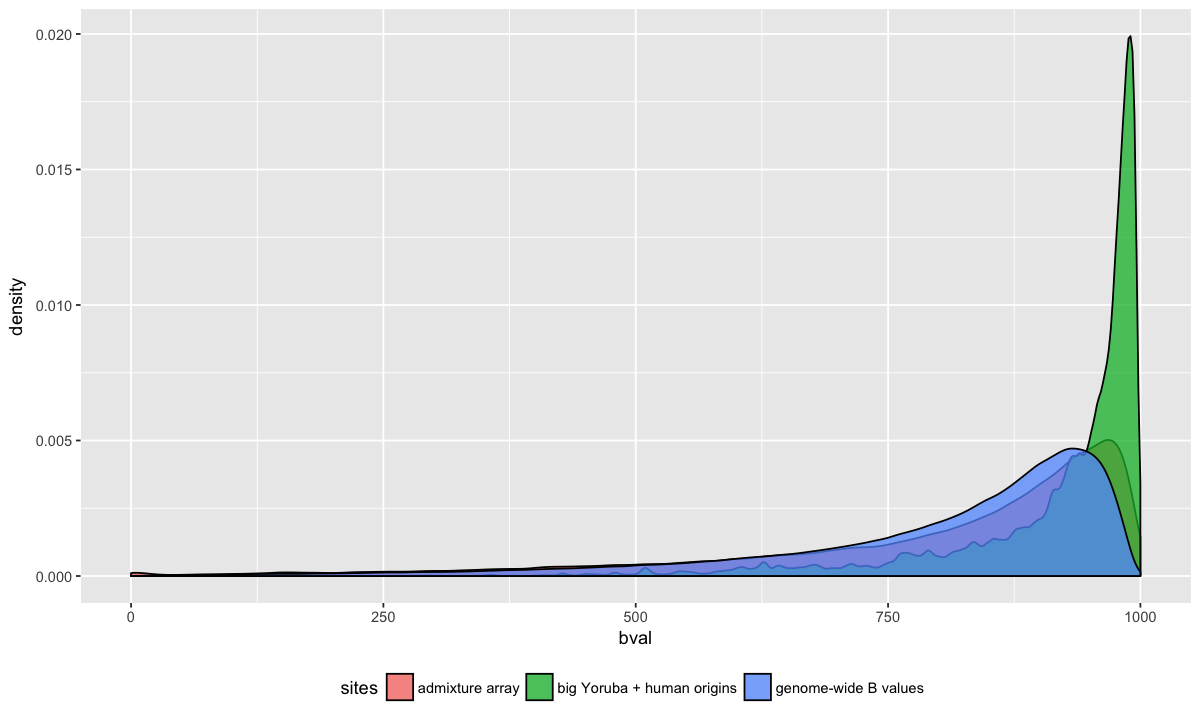

In [14]:
options(repr.plot.width=10, repr.plot.height=6)

ggplot(bvals, aes(bval, fill=sites)) +
    geom_density(alpha=0.75) +
    scale_colour_manual(values = c("red", "green", "blue")) + 
    theme(legend.position="bottom")

In [27]:
group_by(bvals, sites) %>% summarise(mean(bval, na.rm=TRUE), sd(bval, na.rm=TRUE), quantile(na.rm=TRUE, bval, probs=0.1))

sites,"mean(bval, na.rm = TRUE)","sd(bval, na.rm = TRUE)","quantile(na.rm = TRUE, bval, probs = 0.1)"
admixture array,802.8912,196.8851,514
big Yoruba + human origins,920.9962,102.0883,787
genome-wide B values,803.5139,172.9799,561


# This is crazy! Nearly all 2.2M sites are within high B value regions.

This makes the huge decline from 5-6% to 1-2% today even more unlikely.

In [90]:
table(f4_sites$bin)


    (0,100]   (100,200]   (200,300]   (300,400]   (400,500]   (500,600] 
          0           0         493        2324       10725       28619 
  (600,700]   (700,800]   (800,900] (900,1e+03] 
      64828      112023      259126     1466127 

# Simulations of no Nea admixture

In [1]:
suppressPackageStartupMessages({

library(tidyverse)

source("../R/utils.R")
source("../R/admixr.R")
source("../R/assign_bvals.R")

})

Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg18’ was built under R version 3.4.0”

In [2]:
prefix <- "bval_geno_files"

files <- lapply(seq(0.1, 1, 0.1), function(bin) {
   tibble(
       bin=bin,
       par_file=paste0(prefix, "_", bin, ".par"),
       pop_file=paste0(prefix, "_", bin, ".pop"),
       log_file=paste0(prefix, "_", bin, ".log"),
       eigenstrat_prefix=paste0(prefix, "_", bin)
    )
}) %>% bind_rows

In [3]:
setwd("../raw_data/bval_geno_files/")

In [4]:
files

bin,par_file,pop_file,log_file,eigenstrat_prefix
0.1,bval_geno_files_0.1.par,bval_geno_files_0.1.pop,bval_geno_files_0.1.log,bval_geno_files_0.1
0.2,bval_geno_files_0.2.par,bval_geno_files_0.2.pop,bval_geno_files_0.2.log,bval_geno_files_0.2
0.3,bval_geno_files_0.3.par,bval_geno_files_0.3.pop,bval_geno_files_0.3.log,bval_geno_files_0.3
0.4,bval_geno_files_0.4.par,bval_geno_files_0.4.pop,bval_geno_files_0.4.log,bval_geno_files_0.4
0.5,bval_geno_files_0.5.par,bval_geno_files_0.5.pop,bval_geno_files_0.5.log,bval_geno_files_0.5
0.6,bval_geno_files_0.6.par,bval_geno_files_0.6.pop,bval_geno_files_0.6.log,bval_geno_files_0.6
0.7,bval_geno_files_0.7.par,bval_geno_files_0.7.pop,bval_geno_files_0.7.log,bval_geno_files_0.7
0.8,bval_geno_files_0.8.par,bval_geno_files_0.8.pop,bval_geno_files_0.8.log,bval_geno_files_0.8
0.9,bval_geno_files_0.9.par,bval_geno_files_0.9.pop,bval_geno_files_0.9.log,bval_geno_files_0.9
1.0,bval_geno_files_1.par,bval_geno_files_1.pop,bval_geno_files_1.log,bval_geno_files_1


In [5]:
f4_in_bins <- apply(files, 1, function(f) {
    create_qpF4ratio_pops(X="European", A="Neandertal1", B="Neandertal2", C="African", O="Chimp", file=f[["pop_file"]])
    create_param_file(f[["par_file"]], f[["pop_file"]], f[["eigenstrat_prefix"]])

    run_cmd("qpF4ratio", f[["par_file"]], f[["log_file"]], admixtools_path="")
    
    read_qpF4ratio(f["log_file"]) %>% mutate(bin=f["bin"])
}) %>% bind_rows

In [6]:
f4_in_bins

A,B,X,C,O,alpha,stderr,z,bin
Neandertal1,Neandertal2,European,African,Chimp,0.000000,0.000000,NaN,0.1
Neandertal1,Neandertal2,European,African,Chimp,0.000000,0.000000,NaN,0.2
Neandertal1,Neandertal2,European,African,Chimp,-0.000012,0.000171,-0.072,0.3
Neandertal1,Neandertal2,European,African,Chimp,0.000160,0.001007,0.159,0.4
Neandertal1,Neandertal2,European,African,Chimp,-0.000863,0.001551,-0.557,0.5
Neandertal1,Neandertal2,European,African,Chimp,-0.000741,0.001378,-0.538,0.6
Neandertal1,Neandertal2,European,African,Chimp,0.003235,0.001759,1.839,0.7
Neandertal1,Neandertal2,European,African,Chimp,-0.000658,0.002340,-0.281,0.8
Neandertal1,Neandertal2,European,African,Chimp,-0.002742,0.002294,-1.195,0.9
Neandertal1,Neandertal2,European,African,Chimp,0.000968,0.002837,0.341,1.0


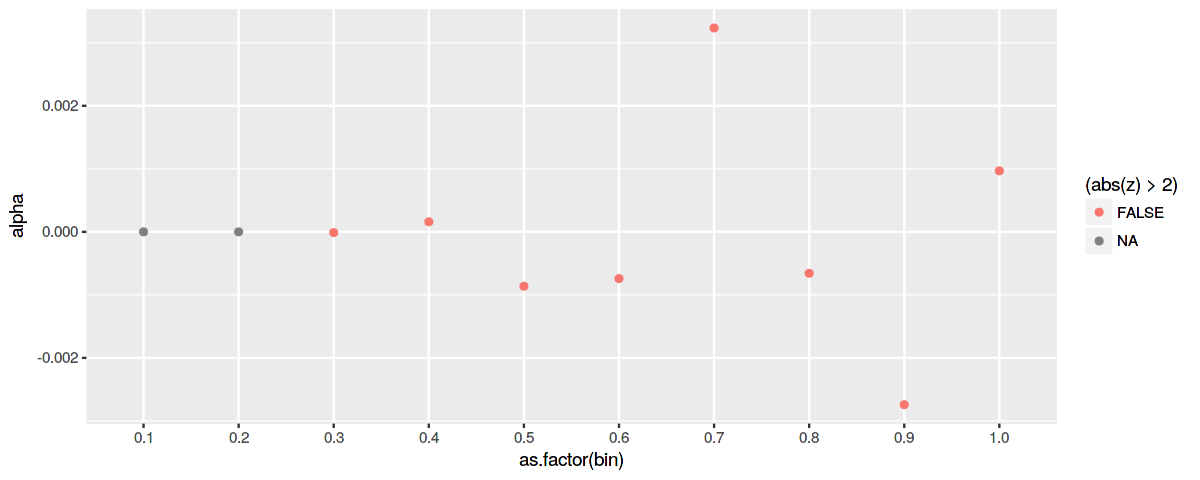

In [7]:
options(repr.plot.width=10, repr.plot.height=4)

ggplot(f4_in_bins) +
    geom_point(aes(as.factor(bin), alpha, color=(abs(z) > 2)))

# Simulations of Nea admixture

In [1]:
suppressPackageStartupMessages({

library(tidyverse)

source("../R/utils.R")
source("../R/admixr.R")
source("../R/assign_bvals.R")

})

Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg18’ was built under R version 3.4.0”

In [2]:
prefix <- "bval_geno_files"

files <- lapply(seq(0.1, 1, 0.1), function(bin) {
   tibble(
       bin=bin,
       par_file=paste0(prefix, "_", bin, "_nea_adm_500_002_.par"),
       pop_file=paste0(prefix, "_", bin, "_nea_adm_500_002_.pop"),
       log_file=paste0(prefix, "_", bin, "_nea_adm_500_002_.log"),
       eigenstrat_prefix=paste0(prefix, "_", bin, "_nea_adm_500_002_")
    )
}) %>% bind_rows

In [3]:
setwd("../raw_data/bval_geno_files_nea_adm/")

In [4]:
head(files)

bin,par_file,pop_file,log_file,eigenstrat_prefix
0.1,bval_geno_files_0.1_nea_adm_500_002_.par,bval_geno_files_0.1_nea_adm_500_002_.pop,bval_geno_files_0.1_nea_adm_500_002_.log,bval_geno_files_0.1_nea_adm_500_002_
0.2,bval_geno_files_0.2_nea_adm_500_002_.par,bval_geno_files_0.2_nea_adm_500_002_.pop,bval_geno_files_0.2_nea_adm_500_002_.log,bval_geno_files_0.2_nea_adm_500_002_
0.3,bval_geno_files_0.3_nea_adm_500_002_.par,bval_geno_files_0.3_nea_adm_500_002_.pop,bval_geno_files_0.3_nea_adm_500_002_.log,bval_geno_files_0.3_nea_adm_500_002_
0.4,bval_geno_files_0.4_nea_adm_500_002_.par,bval_geno_files_0.4_nea_adm_500_002_.pop,bval_geno_files_0.4_nea_adm_500_002_.log,bval_geno_files_0.4_nea_adm_500_002_
0.5,bval_geno_files_0.5_nea_adm_500_002_.par,bval_geno_files_0.5_nea_adm_500_002_.pop,bval_geno_files_0.5_nea_adm_500_002_.log,bval_geno_files_0.5_nea_adm_500_002_
0.6,bval_geno_files_0.6_nea_adm_500_002_.par,bval_geno_files_0.6_nea_adm_500_002_.pop,bval_geno_files_0.6_nea_adm_500_002_.log,bval_geno_files_0.6_nea_adm_500_002_


In [12]:
f4_in_bins_nea_adm <- apply(files, 1, function(f) {
    create_qpF4ratio_pops(X="European", A="Neandertal1", B="Neandertal2", C="African", O="Chimp", file=f[["pop_file"]])
    create_param_file(f[["par_file"]], f[["pop_file"]], f[["eigenstrat_prefix"]])

    run_cmd("qpF4ratio", f[["par_file"]], f[["log_file"]], admixtools_path="")
    
    read_qpF4ratio(f["log_file"]) %>% mutate(bin=f["bin"])
}) %>% bind_rows

In [13]:
f4_in_bins_nea_adm

A,B,X,C,O,alpha,stderr,z,bin
Neandertal1,Neandertal2,European,African,Chimp,0.556911,0.005615,99.190,0.1
Neandertal1,Neandertal2,European,African,Chimp,0.546524,0.006342,86.179,0.2
Neandertal1,Neandertal2,European,African,Chimp,0.559975,0.004803,116.599,0.3
Neandertal1,Neandertal2,European,African,Chimp,0.542061,0.008396,64.558,0.4
Neandertal1,Neandertal2,European,African,Chimp,0.546612,0.009612,56.870,0.5
Neandertal1,Neandertal2,European,African,Chimp,0.543535,0.006384,85.138,0.6
Neandertal1,Neandertal2,European,African,Chimp,0.557427,0.006155,90.567,0.7
Neandertal1,Neandertal2,European,African,Chimp,0.545378,0.007037,77.505,0.8
Neandertal1,Neandertal2,European,African,Chimp,0.555975,0.008526,65.207,0.9
Neandertal1,Neandertal2,European,African,Chimp,0.561338,0.006796,82.594,1.0


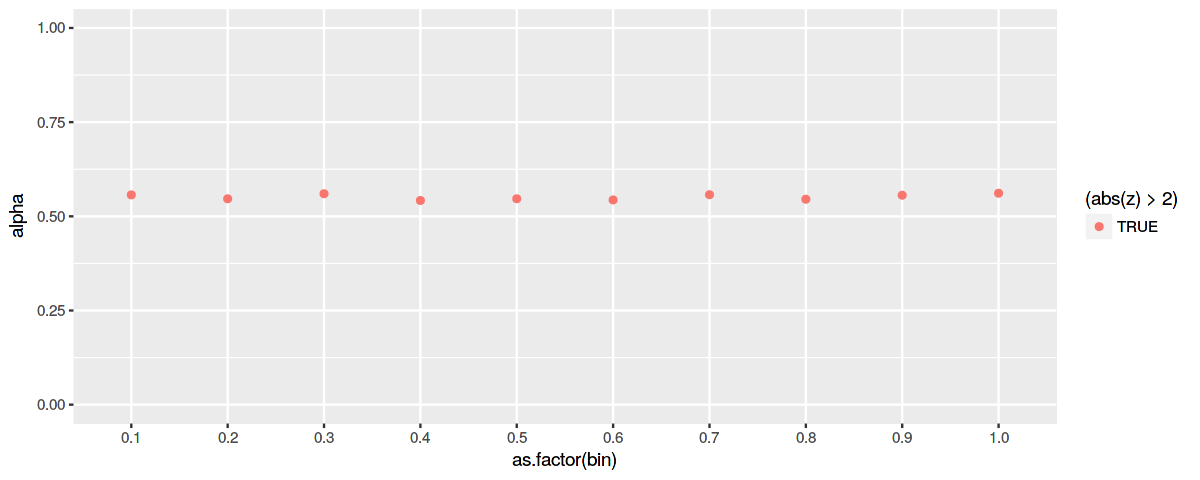

In [14]:
options(repr.plot.width=10, repr.plot.height=4)

ggplot(f4_in_bins_nea_adm) +
    geom_point(aes(as.factor(bin), alpha, color=(abs(z) > 2))) +
    ylim(0, 1)

# Simulations of Nea admixture that includes MH<->Africa admixture

In [1]:
suppressPackageStartupMessages({

library(tidyverse)

source("../R/utils.R")
source("../R/admixr.R")
source("../R/assign_bvals.R")

})

Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg18’ was built under R version 3.4.0”

In [15]:
prefix <- "bval_geno_files"

files <- lapply(seq(0.1, 1, 0.1), function(bin) {
   tibble(
       bin=bin,
       par_file=paste0(prefix, "_", bin, "_nea_adm_500_002_mh_mig1_.par"),
       pop_file=paste0(prefix, "_", bin, "_nea_adm_500_002_mh_mig1_.pop"),
       log_file=paste0(prefix, "_", bin, "_nea_adm_500_002_mh_mig1_.log"),
       eigenstrat_prefix=paste0(prefix, "_", bin, "_nea_adm_500_002_mh_mig1_")
    )
}) %>% bind_rows

In [16]:
setwd("../bval_geno_files_nea_adm_mh_mig/")

In [17]:
head(files)

bin,par_file,pop_file,log_file,eigenstrat_prefix
0.1,bval_geno_files_0.1_nea_adm_500_002_mh_mig1_.par,bval_geno_files_0.1_nea_adm_500_002_mh_mig1_.pop,bval_geno_files_0.1_nea_adm_500_002_mh_mig1_.log,bval_geno_files_0.1_nea_adm_500_002_mh_mig1_
0.2,bval_geno_files_0.2_nea_adm_500_002_mh_mig1_.par,bval_geno_files_0.2_nea_adm_500_002_mh_mig1_.pop,bval_geno_files_0.2_nea_adm_500_002_mh_mig1_.log,bval_geno_files_0.2_nea_adm_500_002_mh_mig1_
0.3,bval_geno_files_0.3_nea_adm_500_002_mh_mig1_.par,bval_geno_files_0.3_nea_adm_500_002_mh_mig1_.pop,bval_geno_files_0.3_nea_adm_500_002_mh_mig1_.log,bval_geno_files_0.3_nea_adm_500_002_mh_mig1_
0.4,bval_geno_files_0.4_nea_adm_500_002_mh_mig1_.par,bval_geno_files_0.4_nea_adm_500_002_mh_mig1_.pop,bval_geno_files_0.4_nea_adm_500_002_mh_mig1_.log,bval_geno_files_0.4_nea_adm_500_002_mh_mig1_
0.5,bval_geno_files_0.5_nea_adm_500_002_mh_mig1_.par,bval_geno_files_0.5_nea_adm_500_002_mh_mig1_.pop,bval_geno_files_0.5_nea_adm_500_002_mh_mig1_.log,bval_geno_files_0.5_nea_adm_500_002_mh_mig1_
0.6,bval_geno_files_0.6_nea_adm_500_002_mh_mig1_.par,bval_geno_files_0.6_nea_adm_500_002_mh_mig1_.pop,bval_geno_files_0.6_nea_adm_500_002_mh_mig1_.log,bval_geno_files_0.6_nea_adm_500_002_mh_mig1_


In [18]:
f4_in_bins_mh_migr <- apply(files, 1, function(f) {
    create_qpF4ratio_pops(X="European", A="Neandertal1", B="Neandertal2", C="African", O="Chimp", file=f[["pop_file"]])
    create_param_file(f[["par_file"]], f[["pop_file"]], f[["eigenstrat_prefix"]])

    run_cmd("qpF4ratio", f[["par_file"]], f[["log_file"]], admixtools_path="")
    
    read_qpF4ratio(f["log_file"]) %>% mutate(bin=f["bin"])
}) %>% bind_rows

In [19]:
f4_in_bins_mh_migr

A,B,X,C,O,alpha,stderr,z,bin
Neandertal1,Neandertal2,European,African,Chimp,0.503398,0.006591,76.380,0.1
Neandertal1,Neandertal2,European,African,Chimp,0.507392,0.008344,60.809,0.2
Neandertal1,Neandertal2,European,African,Chimp,0.499534,0.006773,73.754,0.3
Neandertal1,Neandertal2,European,African,Chimp,0.517759,0.006080,85.158,0.4
Neandertal1,Neandertal2,European,African,Chimp,0.519350,0.007542,68.862,0.5
Neandertal1,Neandertal2,European,African,Chimp,0.518489,0.005031,103.054,0.6
Neandertal1,Neandertal2,European,African,Chimp,0.516231,0.005603,92.135,0.7
Neandertal1,Neandertal2,European,African,Chimp,0.508758,0.007693,66.131,0.8
Neandertal1,Neandertal2,European,African,Chimp,0.508504,0.005087,99.961,0.9
Neandertal1,Neandertal2,European,African,Chimp,0.502760,0.008794,57.173,1.0


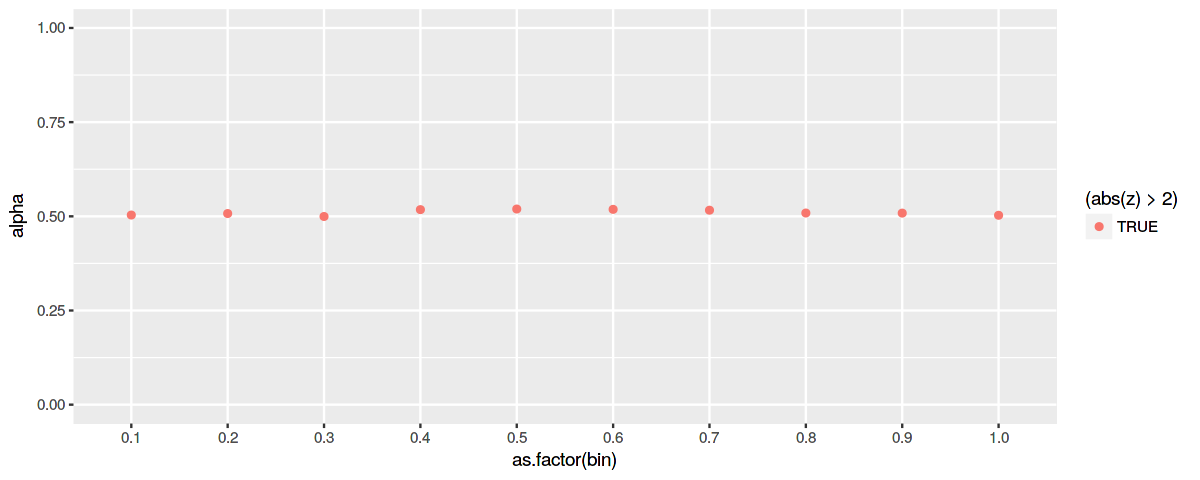

In [20]:
options(repr.plot.width=10, repr.plot.height=4)

ggplot(f4_in_bins_mh_migr) +
    geom_point(aes(as.factor(bin), alpha, color=(abs(z) > 2))) +
    ylim(0, 1)

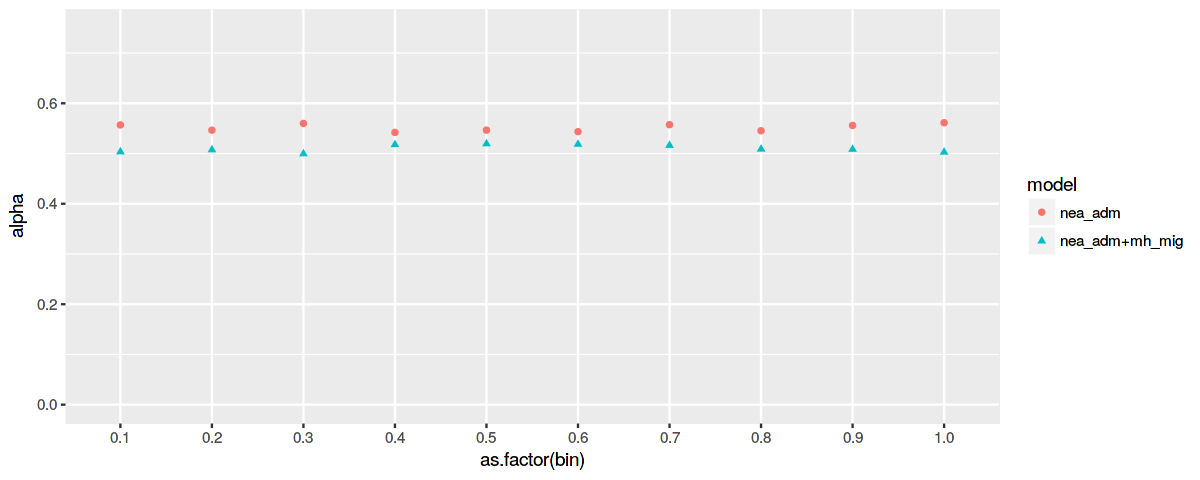

In [26]:
bind_rows(
    f4_in_bins_nea_adm %>% mutate(model="nea_adm"),
    f4_in_bins_mh_migr %>% mutate(model="nea_adm+mh_mig")
) %>%
    ggplot +
        geom_point(aes(as.factor(bin), alpha, shape=model, color=model)) +
        ylim(0, 0.75)